<a href="https://colab.research.google.com/github/Deksed/all_cups_missing_plane/blob/main/missing_planes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from google.colab import drive
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import os
%matplotlib inline

2.5.0


In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
class MissingPlanesCallback(keras.callbacks.Callback):
  pass

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/all_cups/missing_planes/data/train.csv', dtype=str)
data_test = pd.read_csv('/content/drive/MyDrive/all_cups/missing_planes/data/test.csv', dtype=str)
data_train.head(3)

,sign,filename
0,0,200d8766-4240-44d1-a2da-65dc4ee7973a
1,0,87174854-b7b6-4cb2-8183-4ca2bbd26b9d
2,0,c089638e-b683-436a-a3a3-3e5be972c4f6


In [ ]:
def append_png(fn):
    return fn+".png"
data_train["png"]=data_train["filename"].apply(append_png)
data_test["png"]=data_test["filename"].apply(append_png)

In [ ]:
data_train.head(3)

,sign,filename,png
0,0,200d8766-4240-44d1-a2da-65dc4ee7973a,200d8766-4240-44d1-a2da-65dc4ee7973a.png
1,0,87174854-b7b6-4cb2-8183-4ca2bbd26b9d,87174854-b7b6-4cb2-8183-4ca2bbd26b9d.png
2,0,c089638e-b683-436a-a3a3-3e5be972c4f6,c089638e-b683-436a-a3a3-3e5be972c4f6.png


In [ ]:
samples = np.random.rand(len(data_train)) < 0.8
df_train = data_train[samples]
df_test = data_train[~samples]

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31080 entries, 0 to 31079
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sign      31080 non-null  object
 1   filename  31080 non-null  object
 2   png       31080 non-null  object
dtypes: object(3)
memory usage: 728.6+ KB


In [ ]:
base_dir = '/content/drive/MyDrive/all_cups/missing_planes/data/'
train_dir = '/content/drive/MyDrive/all_cups/missing_planes/data/avia-train'
test_dir = '/content/drive/MyDrive/all_cups/missing_planes/data/avia-test'
cpt_path = '/content/drive/MyDrive/all_cups/missing_planes/data/models/'

In [ ]:
BATCH_SIZE=128
IMAGE_SIZE = 20
train_gen = ImageDataGenerator(
    rotation_range=45,
    rescale=1./255, 
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data = train_gen.flow_from_dataframe(dataframe=df_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

val_data = train_gen.flow_from_dataframe(dataframe=df_test, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

test_data = test_gen.flow_from_dataframe(dataframe=data_test, 
                                         directory=test_dir, x_col='png', 
                                         y_col=None,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         class_mode=None,
                                         validate_filenames=False,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE))

full_data = train_gen.flow_from_dataframe(dataframe=data_train, 
                                           directory=train_dir, x_col='png', 
                                           y_col='sign', seed=42, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,  
                                           class_mode='binary',
                                           validate_filenames=False,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 24859 non-validated image filenames belonging to 2 classes.
Found 6221 non-validated image filenames belonging to 2 classes.
Found 1000 non-validated image filenames.
Found 31080 non-validated image filenames belonging to 2 classes.


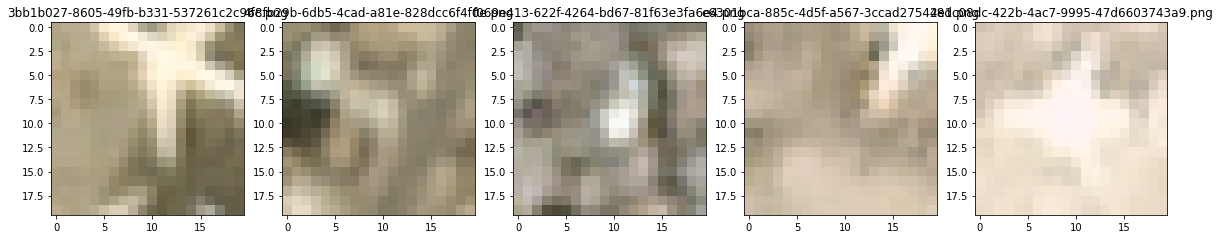

In [ ]:
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(train_dir))
    image_path= os.path.join(train_dir, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [ ]:
def make_model(dropout=0.0):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                  activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                  activation='relu', padding='same'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=[tf.keras.metrics.AUC()])
  return model

model = make_model(dropout=0.5)

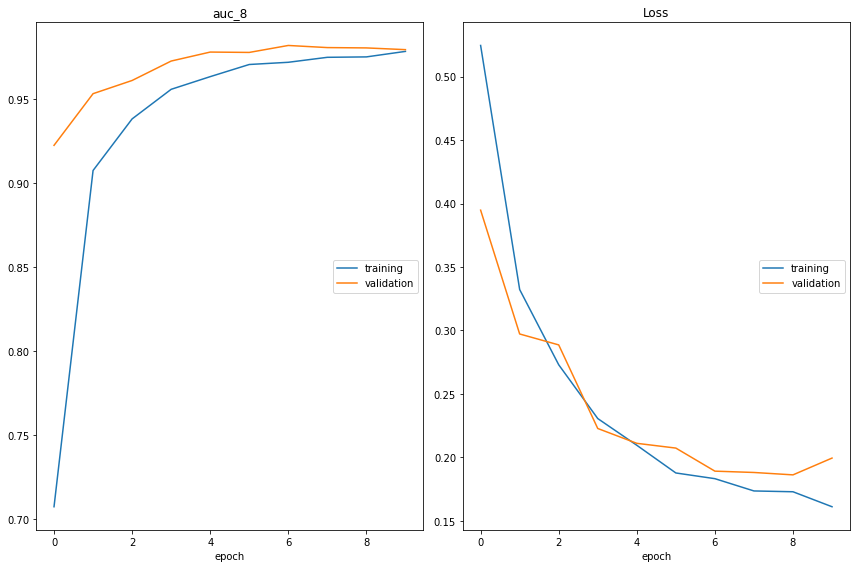

auc_8
	training         	 (min:    0.707, max:    0.979, cur:    0.979)
	validation       	 (min:    0.923, max:    0.982, cur:    0.980)
Loss
	training         	 (min:    0.161, max:    0.524, cur:    0.161)
	validation       	 (min:    0.186, max:    0.395, cur:    0.200)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, save_best_only=True)

EPOCHS = 10
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, PlotLossesCallback()])

In [ ]:
fpr, tpr, thresholds = roc_curve(df_test['sign'].astype(int), val_data_pred)

In [ ]:
val_data_pred = model.predict(val_data)

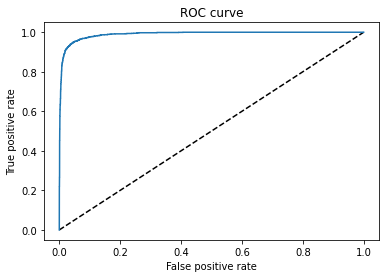

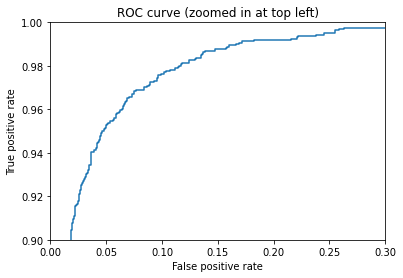

In [ ]:
def plot_roc_curve(fpr,tpr): 
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()
  # Zoom in view of the upper left corner.
  plt.figure(2)
  plt.xlim(0, 0.3)
  plt.ylim(0.9, 1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve (zoomed in at top left)')
  plt.show()

plot_roc_curve(fpr,tpr) 

In [ ]:
auc_score=roc_auc_score(df_test['sign'].astype(int), val_data_pred)
auc_score

0.9897856629189834

In [ ]:
# FULL DATA

In [ ]:
def submit(data_test, predict, auc=0.9):
  test = pd.DataFrame(predict, columns=['Predict'])
  result = pd.concat([data_test, test], axis=1)
  result['sign']  = result['Predict'].apply(lambda x: 1 if x > auc else 0)
  result.drop(['png', 'Predict'], axis=1, inplace=True)
  result.to_csv('Subbmision.csv', columns=['sign', 'filename'], index=False)

In [ ]:
def full_model_learn(EPOCHS):
  model.fit(full_data, epochs=EPOCHS, callbacks=[checkpoint, PlotLossesCallback()])
  model_best = make_model(dropout=0.5)
  model_best.load_weights(cpt_path)
  predict = model.predict(test_data)
  return predict
  # submit(data_test, predict, 0.9)

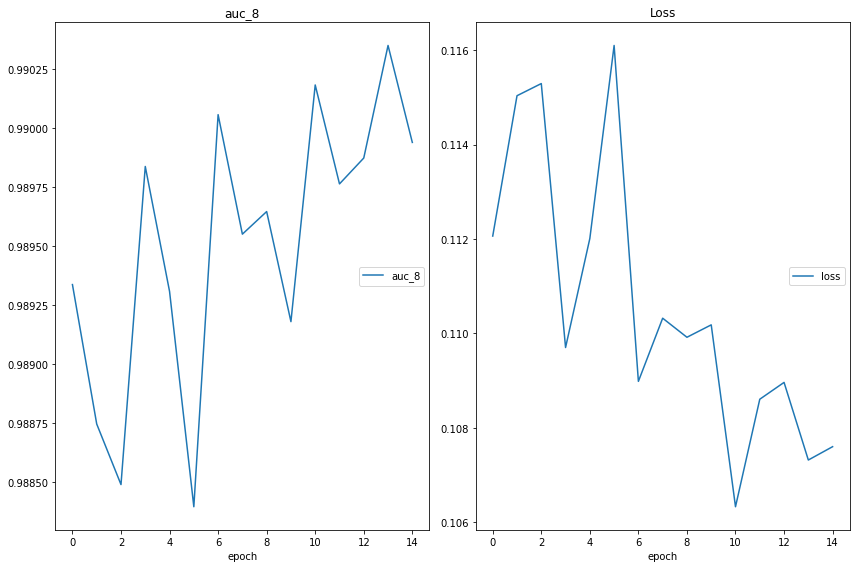

auc_8
	auc_8            	 (min:    0.988, max:    0.990, cur:    0.990)
Loss
	loss             	 (min:    0.106, max:    0.116, cur:    0.108)


In [ ]:
full_pred = full_model_learn(15)

In [ ]:
submit(data_test, full_pred, auc=0.24)

In [ ]:
#-------------------------------------------------------------------------------------------

In [ ]:
pred = model.predict(val_data)

In [ ]:
test = pd.DataFrame(pred, columns=['Predict'])
test.head()

,Predict
0,0.000771
1,0.000253
2,0.004452
3,0.000117
4,0.046409


In [ ]:
df_test['sign'].astype(int).sum()

1606

In [ ]:
for i in np.arange(0, 1, 0.005):
  test['sign' + '_' + str(i)]  = result['Predict'].apply(lambda x: 1 if x > i else 0)
test.head()
for col in test.columns:
  print(col, test[col].astype(int).sum())

Predict 0
sign_0.0 6221
sign_0.025 2484
sign_0.05 2166
sign_0.07500000000000001 2001
sign_0.1 1887
sign_0.125 1802
sign_0.15000000000000002 1743
sign_0.17500000000000002 1693
sign_0.2 1665
sign_0.225 1618
sign_0.25 1584
sign_0.275 1550
sign_0.30000000000000004 1529
sign_0.325 1497
sign_0.35000000000000003 1468
sign_0.375 1440
sign_0.4 1405
sign_0.42500000000000004 1374
sign_0.45 1344
sign_0.47500000000000003 1311
sign_0.5 1277
sign_0.525 1251
sign_0.55 1220
sign_0.5750000000000001 1183
sign_0.6000000000000001 1138
sign_0.625 1094
sign_0.65 1065
sign_0.675 1021
sign_0.7000000000000001 966
sign_0.7250000000000001 919
sign_0.75 860
sign_0.775 791
sign_0.8 737
sign_0.8250000000000001 664
sign_0.8500000000000001 593
sign_0.875 500
sign_0.9 424
sign_0.925 315
sign_0.9500000000000001 212
sign_0.9750000000000001 82
sign_0.005 3204
sign_0.01 2899
sign_0.015 2715
sign_0.02 2580
sign_0.03 2401
sign_0.035 2318
sign_0.04 2253
sign_0.045 2215
sign_0.055 2130
sign_0.06 2087
sign_0.065 2052
sign_0.07 